In [1]:
import numpy as np
import numpy.linalg as l
import matplotlib.pyplot as plt
import math

In [2]:
class EvaluationException(Exception):
    pass

def is_defective(eigenvalues, error_tol = 1e-8):
    for v in range(len(eigenvalues)):
        if eigenvalues[v] < error_tol:
            return True
        for t in range(len(eigenvalues)):
            if v != t and (abs((eigenvalues[v] - eigenvalues[t])/eigenvalues[v]) < error_tol and 
                           abs((eigenvalues[v] - eigenvalues[t])/eigenvalues[t]) < error_tol):
                return True
    return False

def array_multi(arr, level):
    if level < 0:
        raise EvaluationException("Negative level values are meaningless")
    
    if level == 0:
        return np.diag([1] * len(arr))
    
    curr_val = arr
    curr_level = level
    while curr_level > 1:
        curr_val = curr_val @ arr
        curr_level -= 1
        
    return curr_val

def array_exp(arr, error_tol = 1e-4):
    if len(arr) != len(np.transpose(arr)):
        raise EvaluationException("Only squared arrays are accepted for exponentiation.")
    
    over_tol = True
    
    curr_val = array_multi(arr, 0)
    level = 1
    while over_tol: 
        next_val = array_multi(arr, level) / math.factorial(level)
        curr_val = curr_val + next_val
        if np.all(next_val < error_tol):
            over_tol = False
        level += 1
        
    return curr_val
    
def point_analytic_ode_system(A, u0, error_tol = 1e-8):
    """Solve Linear system analitically, where A is the array for du/dt = Au, 
    and u0 are the initial values of u"""
    len_A = len(A)
    if len_A != len(np.transpose(A)):
        raise EvaluationException("It's not possible to solve an EDO system if A is not a square matrix.")
        
    if len_A != len(u0):
        raise EvaluationException("Wrong number of u0 initial conditions.")
    
    #
    # Return a function which evaluates u(t) for all t
    #
    eigenvalues, eigenvectors = l.eig(A)
    
    # If Array is defective, uses the Exponential definition
    if is_defective(eigenvalues):
        return lambda t: array_exp(A * t, error_tol) @ u0
    
    # Otherwise, returns an analytic solution using eigenvalues and eigenvectors:
    return lambda t: eigenvectors @ np.diag(np.exp(eigenvalues * t)) @ l.inv(eigenvectors) @ u0

def analytic_ode_system(A, u0, start = 0, end = 5, h = 0.01):
    """Evaluate the analytic solution to the system."""
    t = np.arange(start, end + h, h)
    analytic_solution = point_analytic_ode_system(np.array(A), np.array(u0))
    u = [analytic_solution(tn) for tn in t]
    return np.vstack((t, np.transpose(u)))
    
def numeric_ode_system(A, u0, start = 0, end = 5, h = 0.01):
    """Evaluate numeric solution to the system"""
    t = np.arange(start, end + h, h)
    aa = np.array(A)
    u = [np.array(u0)]
    for i in range(len(t) - 1):
        u.append(u[i] + h * (aa @ u[i]))
    return np.vstack((t, np.transpose(u)))
   
    

In [6]:
a_res = analytic_ode_system([[2, -1],[0, 1]], [1,1])
n_res = numeric_ode_system([[2, -1],[0, 1]], [1,1])

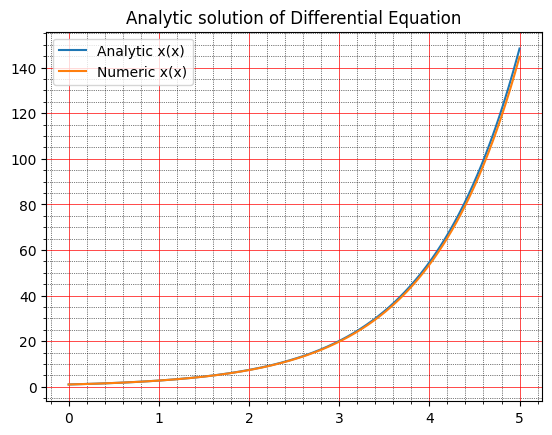

In [7]:
fig, ax = plt.subplots()

at_n = a_res[0]
ax_n = a_res[1]
nt_n = n_res[0]
nx_n = n_res[1]

plt.plot(at_n, ax_n, label="Analytic x(x)")
plt.plot(nt_n, nx_n, label="Numeric x(x)")

ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title("Analytic solution of Differential Equation")
plt.legend()

ax = plt.gca()